In [1]:
import json
import datetime as dt
import requests
import numpy as np
import pandas as pd
import bayes_opt as bo

from IPython.utils import io
from sklearn.metrics import mean_squared_error, mean_absolute_error
from seirsplus.models import SEIRSModel
from bayesian_search_helpers import seirs_prediction, loss_function, custom_loss

## Example

In [10]:
def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

In [11]:
# Bounded region of parameter space
pbounds = {'x': (2, 4), 'y': (-3, 3)}

optimizer = bo.BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

In [12]:
optimizer.maximize(
    init_points=5,
    n_iter=10,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -7.135    |  2.834    |  1.322    |
|  2        | -7.78     |  2.0      | -1.186    |
|  3        | -16.13    |  2.294    | -2.446    |
|  4        | -8.341    |  2.373    | -0.9266   |
|  5        | -7.392    |  2.794    |  0.2329   |
|  6        | -15.02    |  4.0      |  0.8624   |
|  7        | -3.799    |  2.184    |  0.83     |
|  8        | -5.343    |  2.0      |  2.531    |
|  9        | -14.29    |  3.36     |  3.0      |
|  10       | -3.363    |  2.0      |  1.603    |
|  11       | -3.873    |  2.0      |  0.06544  |
|  12       | -3.012    |  2.0      |  1.108    |
|  13       | -3.072    |  2.0      |  0.7319   |
|  14       | -3.003    |  2.0      |  0.9457   |
|  15       | -3.0      |  2.0      |  1.007    |


## SEIR Optimization

Here we should introduce an abstract class that takes a model and a dictionary of parameters and ranges. This class then has a method that optimizes the parameters via Bayesian Optimization on call.

#### Load Data

In [13]:
response_US_Daily = requests.request("GET", "https://covidtracking.com/api/us/daily", headers={}, data={})

US_daily = pd.DataFrame(json.loads(response_US_Daily.text))

US_daily['date'] = pd.to_datetime(US_daily['date'], format='%Y%m%d')
US_daily.set_index('date', inplace=True)
US_daily.sort_values('date')
US_daily.head()

,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,lastModified,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,hash
date,,,,,,,,,,,,,,,,,,,,,
2020-07-24,56,4092928,45745166,3409.0,59670.0,289355.0,10288.0,13182.0,2712.0,1297.0,...,2020-07-24T00:00:00Z,49841503,49838094,49838094,1178,3026,854645,75193,929838,12df42387588e4187c573031bd050ea724720a82
2020-07-23,56,4017735,44890521,3179.0,59885.0,286329.0,10466.0,12933.0,2472.0,1280.0,...,2020-07-23T00:00:00Z,48911435,48908256,48908256,1039,2500,753372,71027,824399,c7d29139144a768dd70fb305be3246f8c5b25a42
2020-07-22,56,3946708,44137149,3051.0,59675.0,283829.0,10457.0,12790.0,2440.0,1258.0,...,2020-07-22T00:00:00Z,48086908,48083857,48083857,1117,2248,726352,69150,795502,c28c2ce1af7dcb4a6dfc783c222acb7387b19277
2020-07-21,56,3877558,43410797,3197.0,59362.0,281581.0,6711.0,12629.0,2414.0,1242.0,...,2020-07-21T00:00:00Z,47291552,47288355,47288355,1038,2551,686606,63642,750248,b315275d3d2251da5af96422594a53d6d0508aad
2020-07-20,56,3813916,42724191,3003.0,58371.0,279030.0,6558.0,12475.0,2403.0,1223.0,...,2020-07-20T00:00:00Z,46541110,46538107,46538107,362,1647,654044,56971,711015,6223e4e1a7003f68d8bd1f30742ea4d8e283b834


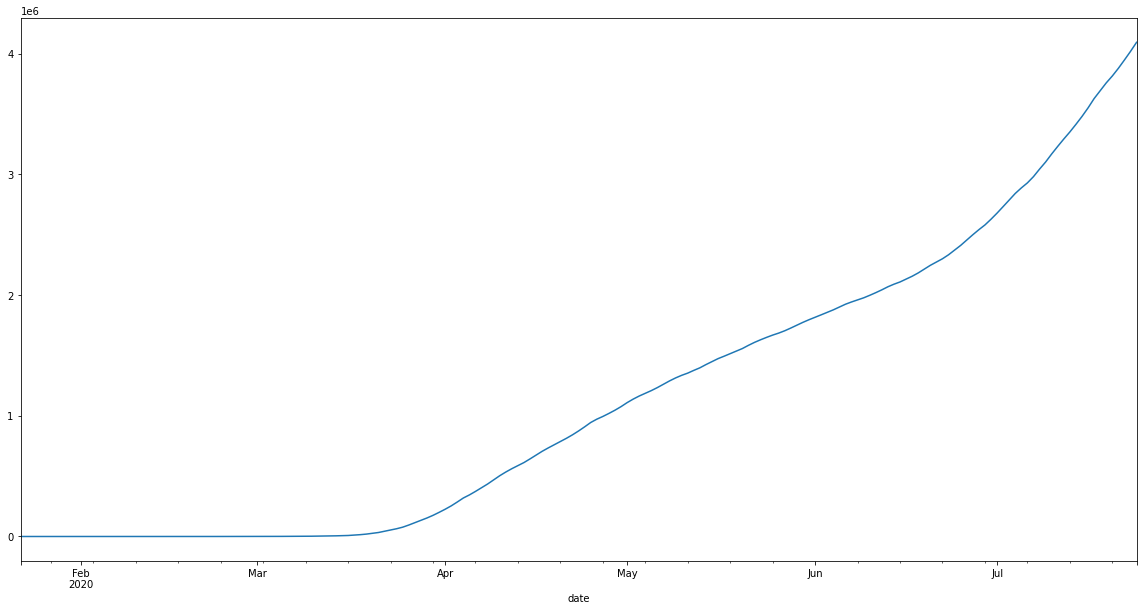

In [14]:
US_daily.positive.plot(figsize=(20, 10));

#### Test run

In [15]:
date_start = '2020-07-01'  # later to change for the '2020-07-27'
USA_population = 328200000  # USA population according to a random internet source

# TO OPTIMIZE WITH MAGIC, SORCERY AND ENCHANTMENTS
beta = 0.155    # Rate of transmission
sigma = 1/5.2   # Rate of progression
gamma = 1/12.39 # Rate of recovery
xi = 0.001      # Rate of re-susceptibility

# Apply the model and optain a prediction for the next 15 days
infected_next_15_days = seirs_prediction(initI=US_daily[date_start]['positive'],
                                         initN=USA_population,
                                         T=15, beta=beta, sigma=sigma, gamma=gamma, xi=xi)

print('Predictions from the next 15 days: ', [np.floor(x) for x in infected_next_15_days])

t = 14.90
Predictions from the next 15 days:  [2848677.0, 3027748.0, 3200731.0, 3371203.0, 3541576.0, 3713927.0, 3889903.0, 4070469.0, 4256506.0, 4448912.0, 4648397.0, 4855347.0, 5070173.0, 5293338.0, 5525360.0]


#### Compute Error

In [16]:
start = dt.datetime.strptime(date_start, '%Y-%m-%d')
start = start + dt.timedelta(days=1)

time_delta = dt.timedelta(days=14)
end = start + time_delta

real_positives = []

step = dt.timedelta(days=1)

while start <= end:
    day = start.strftime('%Y-%m-%d')
    real_positives.append(US_daily[day]['positive'].values[0])  # date()
    start += step

print('Real cases: ', real_positives)

MSE = loss_function(predicted_values=infected_next_15_days, real_values=real_positives)
MAE = custom_loss(predicted_values=infected_next_15_days, real_values=real_positives)
weighted_MAE = custom_loss(predicted_values=infected_next_15_days,
                                     real_values=real_positives,
                                     sample_weight=[1 for i in range(0, 15)])

print('MSE: ', MSE)
print('MAE: ', MAE)
print('MAE weights: ', weighted_MAE)

#print('2020-07-01 : ', US_daily[start_date]['positive'])

Real cases:  [2732244, 2786467, 2841201, 2886990, 2928590, 2980356, 3042503, 3101339, 3167984, 3230991, 3291969, 3350434, 3413313, 3478695, 3549648]
MSE:  1314741024562.1858
MAE:  998636.7218714071
MAE weights:  998636.7218714071


# Test Experiment

In [5]:
# Given parameters
Population = 1000,
InitialInfected = 10

date_start = '2020-07-01'
Infected_at_start = US_daily[date_start]['positive']
USA_population = 328200000

start = dt.datetime.strptime(date_start, '%Y-%m-%d')
start = start + dt.timedelta(days=1)
time_delta = dt.timedelta(days=14)
end = start + time_delta
real_positives = []
step = dt.timedelta(days=1)

while start <= end:
    day = start.strftime('%Y-%m-%d')
    real_positives.append(US_daily[day]['positive'].values[0])  # date()
    start += step

def blackbox(beta, sigma, gamma, xi):
    global real_positives, date_start, USA_population
    infected_next_15_days = seirs_prediction(initI=Infected_at_start, initN=USA_population,
                                             T=15, beta=beta, sigma=sigma, gamma=gamma, xi=xi)

    MSE = loss_function(predicted_values=infected_next_15_days, real_values=real_positives)
    # MAE = custom_loss(predicted_values=infected_next_15_days, real_values=real_positives)
    # weighted_MAE = custom_loss(predicted_values=infected_next_15_days,real_values=real_positives,sample_weight=[1 for i in range(0, 15)])

    return -MSE

In [6]:
# Parameters to tune
parameter_bounds = {
    'beta': (0.1, 0.9),
    'sigma': (1/15, 1/2),
    'gamma': (0, 1),
    'xi': (0, 1/10)
}

optimizer = bo.BayesianOptimization(
    f=blackbox,
    pbounds=parameter_bounds,
    random_state=1,
    verbose=1
)

In [ ]:
# Hyperparameters
init_points = 10
n_iter = 100


with io.capture_output() as captured:
    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter
    )

print(optimizer.max)

## Experiment 1

In [8]:
# Parameters to tune
parameter_bounds = {
    'beta': (0.5, 2),
    'sigma': (1/15, 1/2),
    'gamma': (0, 1),
    'xi': (0, 1/10)
}

optimizer = bo.BayesianOptimization(
    f=blackbox,
    pbounds=parameter_bounds,
    random_state=1,
    verbose=1
)

# Hyperparameters
init_points = 100
n_iter = 1000

with io.capture_output() as captured:
    optimizer.maximize(
        init_points=init_points,
        n_iter=n_iter
    )

print(optimizer.max)

{'target': -3733811552.0895247,
 'params': {'beta': 0.6432749939919991,
  'gamma': 0.5908246958156321,
  'sigma': 0.5,
  'xi': 0.0}}